This notebook does exploratory data analysis and feature engineering. The results are dumped to file for modeling.

#### Exploratary Data Analysis
* load data
* trend of sales
* distribution of target

#### Data Cleaning & Feature Engineering
* heal data and remove outliers
* work with shops/items/cats objects and features
* expand training set to include all item-shop pairs
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats dataframe to training set.
* add group sale stats in recent months
* add lag features
* add trend features
* add month and year
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set

# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [2]:
# load data
items = pd.read_csv('../data/items.csv')
shops = pd.read_csv('../data/shops.csv')
cats = pd.read_csv('../data/item_categories.csv')
train = pd.read_csv('../data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../data/test.csv').set_index('ID')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. 

In [4]:
print('train size, item in train, shop in train', train.shape[0], train.item_id.nunique(), train.shop_id.nunique())
print('train size, item in train, shop in train', test.shape[0], test.item_id.nunique(),test.shop_id.nunique())
print('new items:', len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test))

train size, item in train, shop in train 2935849 21807 60
train size, item in train, shop in train 214200 5100 42
new items: 363 5100 214200


Check for missing values.

In [5]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

There is no missing value in the training set.

Plot the total sale of each month, we see a clear trend and seasonality. The overall sale is decreasing with time, and there are peaks in November.

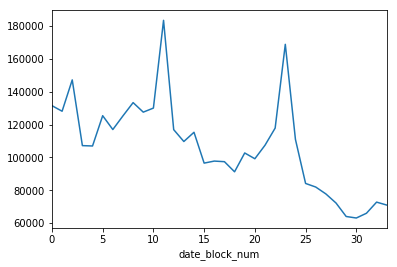

In [6]:
sale_by_month = train.groupby('date_block_num')['item_cnt_day'].sum()
sale_by_month.plot()

The distribution of sale grouped by month, item and shop, we see most item-shop pairs have small monthly sale.

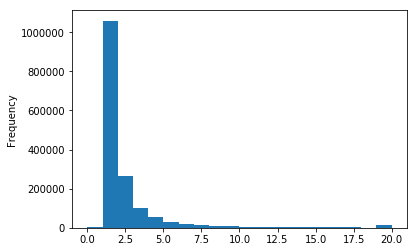

In [7]:
block_item_shop_sale = train.groupby(['date_block_num','item_id','shop_id'])['item_cnt_day'].sum()
block_item_shop_sale.clip(0,20).plot.hist(bins=20)


# Feature engineering and data cleaning

#### remove outliers
Remove outliers with very large item_cnt_day and item_price.

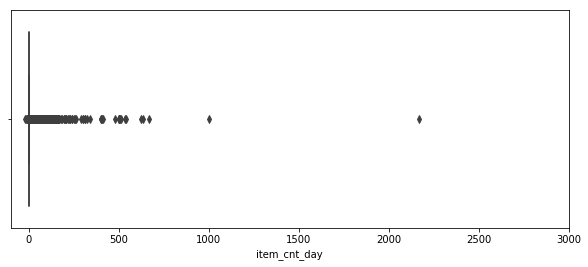

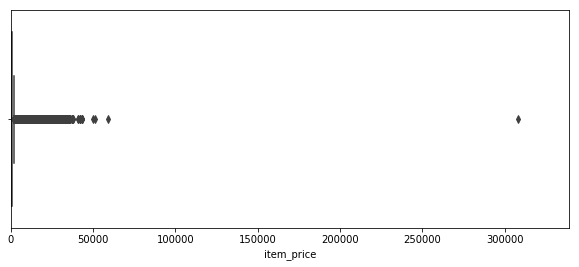

In [8]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [9]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [10]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

#### Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [11]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Most of the items in the test set target value should be zero, while train set contains only pairs which were sold or returned in the past. So we expand the train set to include those item-shop pairs with zero monthly sales. This way train data will be similar to test data.

In [12]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

8.33767056465149

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

Downcast item_cnt_month to float32 -- float16 was too small to perform sum operation.

In [13]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [14]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float32))
time.time() - ts

4.450836658477783

## Test set
To use time tricks append test pairs to the matrix.

In [15]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [16]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.062164306640625

## Shops/Items/Cats features

In [17]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

4.027711629867554

## Traget lags

In [18]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [19]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

28.169410705566406

## Group sale stats in recent
create stats (mean/var) of sales of certain groups during the past 12 months

In [20]:
def add_group_stats(matrix_, groupby_feats, target, enc_feat, last_periods):
    if not 'date_block_num' in groupby_feats:
        print ('date_block_num must in groupby_feats')
        return matrix_
    
    group = matrix_.groupby(groupby_feats)[target].sum().reset_index()
    max_lags = np.max(last_periods)
    for i in range(1,max_lags+1):
        shifted = group[groupby_feats+[target]].copy(deep=True)
        shifted['date_block_num'] += i
        shifted.rename({target:target+'_lag_'+str(i)},axis=1,inplace=True)
        group = group.merge(shifted, on=groupby_feats, how='left')
    group.fillna(0,inplace=True)
    for period in last_periods:
        lag_feats = [target+'_lag_'+str(lag) for lag in np.arange(1,period+1)]
        # we do not use mean and svd directly because we want to include months with sales = 0
        mean = group[lag_feats].sum(axis=1)/float(period)
        mean2 = (group[lag_feats]**2).sum(axis=1)/float(period)
        group[enc_feat+'_avg_sale_last_'+str(period)] = mean
        group[enc_feat+'_std_sale_last_'+str(period)] = (mean2 - mean**2).apply(np.sqrt)
        group[enc_feat+'_std_sale_last_'+str(period)].replace(np.inf,0,inplace=True)
        # divide by mean, this scales the features for NN
        group[enc_feat+'_avg_sale_last_'+str(period)] /= group[enc_feat+'_avg_sale_last_'+str(period)].mean()
        group[enc_feat+'_std_sale_last_'+str(period)] /= group[enc_feat+'_std_sale_last_'+str(period)].mean()
    cols = groupby_feats + [f_ for f_ in group.columns.values if f_.find('_sale_last_')>=0]
    matrix = matrix_.merge(group[cols], on=groupby_feats, how='left')
    return matrix

In [21]:
ts = time.time()
matrix = add_group_stats(matrix, ['date_block_num', 'item_id'], 'item_cnt_month', 'item', [6,12])
matrix = add_group_stats(matrix, ['date_block_num', 'shop_id'], 'item_cnt_month', 'shop', [6,12])
matrix = add_group_stats(matrix, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'category', [12])
matrix = add_group_stats(matrix, ['date_block_num', 'city_code'], 'item_cnt_month', 'city', [12])
matrix = add_group_stats(matrix, ['date_block_num', 'type_code'], 'item_cnt_month', 'type', [12])
matrix = add_group_stats(matrix, ['date_block_num', 'subtype_code'], 'item_cnt_month', 'subtype', [12])
time.time() - ts

22.807144165039062

## Lag features

In [22]:
#first use target encoding each group, then shift month to creat lag features
def target_encoding(matrix_, groupby_feats, target, enc_feat, lags):
    print ('target encoding for',groupby_feats)
    group = matrix_.groupby(groupby_feats).agg({target:'mean'})
    group.columns = [enc_feat]
    group.reset_index(inplace=True)
    matrix = matrix_.merge(group, on=groupby_feats, how='left')
    matrix[enc_feat] = matrix[enc_feat].astype(np.float16)
    matrix = lag_feature(matrix, lags, enc_feat)
    matrix.drop(enc_feat, axis=1, inplace=True)
    return matrix

In [23]:
ts = time.time()
matrix = target_encoding(matrix, ['date_block_num'], 'item_cnt_month', 'date_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'item_id'], 'item_cnt_month', 'date_item_avg_item_cnt', [1,2,3,6,12])
matrix = target_encoding(matrix, ['date_block_num', 'shop_id'], 'item_cnt_month', 'date_shop_avg_item_cnt', [1,2,3,6,12])
matrix = target_encoding(matrix, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'date_cat_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'date_shop_cat_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'city_code'], 'item_cnt_month', 'date_city_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'item_id', 'city_code'], 'item_cnt_month', 'date_item_city_avg_item_cnt', [1])
time.time() - ts

target encoding for ['date_block_num']
target encoding for ['date_block_num', 'item_id']
target encoding for ['date_block_num', 'shop_id']
target encoding for ['date_block_num', 'item_category_id']
target encoding for ['date_block_num', 'shop_id', 'item_category_id']
target encoding for ['date_block_num', 'city_code']
target encoding for ['date_block_num', 'item_id', 'city_code']


148.18005347251892

## Trend features

Price trend for the last six months.

In [24]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

237.32962799072266

Last month shop revenue trend

In [25]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

19.6051344871521

## Add month and year

In [26]:
matrix['month'] = matrix['date_block_num'] % 12
matrix['year'] = (matrix['date_block_num'] / 12).astype(np.int8)

## Add month since the last and first sale
The code has been simplified to reduce run time, though still may not be optimal -- ideally we don't need to compute max for each month.

In [27]:
#Month since last sale for each shop/item pair.
ts = time.time()
last_sale = pd.DataFrame()
for month in range(1,35):    
    last_month = matrix.loc[(matrix['date_block_num']<month)&(matrix['item_cnt_month']>0)].groupby(['item_id','shop_id'])['date_block_num'].max()
    df = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],])*month,
                       'item_id': last_month.index.get_level_values(0).values,
                       'shop_id': last_month.index.get_level_values(1).values,
                       'item_shop_last_sale': last_month.values})
    last_sale = last_sale.append(df)
last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int8)

matrix = matrix.merge(last_sale, on=['date_block_num','item_id','shop_id'], how='left')
time.time() - ts

22.803001880645752

In [28]:
#Month since last sale for each item.
ts = time.time()
last_sale = pd.DataFrame()
for month in range(1,35):    
    last_month = matrix.loc[(matrix['date_block_num']<month)&(matrix['item_cnt_month']>0)].groupby('item_id')['date_block_num'].max()
    df = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],])*month,
                       'item_id': last_month.index.values,
                       'item_last_sale': last_month.values})
    last_sale = last_sale.append(df)
last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int8)

matrix = matrix.merge(last_sale, on=['date_block_num','item_id'], how='left')
time.time() - ts

13.117883443832397

In [29]:
# Months since the first sale for each shop/item pair and for item only.
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

3.172938108444214

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).
Lightgbm and XGBboost can deal with missing values, so we will leave the NaNs as it is. Later for neural network, we will fill na with 0.

In [30]:
matrix = matrix[matrix.date_block_num > 11]
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_avg_sale_last_6', 'item_std_sale_last_6',
       'item_avg_sale_last_12', 'item_std_sale_last_12',
       'shop_avg_sale_last_6', 'shop_std_sale_last_6', 'shop_avg_sale_last_12',
       'shop_std_sale_last_12', 'category_avg_sale_last_12',
       'category_std_sale_last_12', 'city_avg_sale_last_12',
       'city_std_sale_last_12', 'type_avg_sale_last_12',
       'type_std_sale_last_12', 'subtype_avg_sale_last_12',
       'subtype_std_sale_last_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_

In [31]:
matrix.to_pickle('data.pkl')
del matrix
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();